In [570]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Random', 'Random']
seller_strategies = ['Random', 'Random', 'Random','Random', 'Random', 'Random']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 10, 10, 8, 24, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.0

In [571]:
db.round_data.redemption_values.item()

array([[88.4, 69.6, 61.3, 60. , 59.6, 56.4, 43.1, 32.8],
       [86.6, 72. , 52.9, 34.7, 31.9, 26.2, 25.2, 17. ]])

In [572]:
db.round_data.token_costs.item()

array([[ 39.1,  39.3,  52.9,  59.8,  63.7,  73.6,  95. ,  95.4],
       [ 23.8,  32. ,  48.7,  52.7,  70.3,  83.7,  89.1, 100. ],
       [ 24.3,  30.5,  42.5,  69. ,  75.6,  77.5,  84.6,  99.1],
       [ 31.7,  40. ,  48.3,  66.7,  68.6,  71.4,  83.7, 106.5],
       [ 29.5,  40.5,  56.5,  57.8,  81.5,  81.7,  82. ,  97.3],
       [ 27.7,  30.7,  38.4,  38.4,  43. ,  75.5,  85.9,  86.2]])

In [573]:
class TradingEnv(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.rnd = 0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = spaces.Box(0,1,(1,),dtype=np.float32)
        self.observation_space = spaces.Box(-1,200,(13,),dtype=np.float32)

    def reset(self,seed=None):
        #[buyer.next_token() for buyer in self.db.buyers]
        #[seller.next_token() for seller in self.db.sellers]
        #self.db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        self.db.reset_period(self.rnd)
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        self.timestep = 0
        self.period += 1
        self.db.buyers[0].next_token()
        agent = self.db.buyers[0]
        observation = np.array([0,-1,-1,-1,-1,-1,-1,-1,agent.value,-1,-1,-1,agent.num_tokens_traded], dtype = np.float32)
        return observation, {}

    def step(self, action, seed=None, options=None):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        bid_frac = action.item()
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask, current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # compute reward, new state
        reward = 0.0
        if sale == 1 and current_bid_idx == 0:
            reward = bprofit
            
        agent = self.db.buyers[0]
        observation = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded],dtype = np.float32)
        idx = np.isnan(observation)
        observation[idx] = -1.0
        # check termination
        self.timestep += 1
        if self.timestep == nsteps:
            terminated = True
            self.timestep = 0
        else:
            terminated = False
        infos = {"TimeLimit.truncated":True}
        truncated = False
        return observation, reward, terminated, truncated, infos

In [574]:
from stable_baselines3.common.env_checker import check_env
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
check_env(env)

In [ ]:
rnd = 0
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
observation, info = env.reset()
for period in count():
    for timestep in count(): 
        action = env.action_space.sample()
        observation, reward, done, info, _ = env.step(action)
        print(f"Rnd: {rnd}, Period: {period}, New State: {observation}, Action:{np.round(action,1)}, Reward: {np.round(reward,1)}, Period End: {done}")
        if done:
            # If the episode is done, reset the environment
            #print('done')
            observation, info = env.reset()
            break
    if period == nperiods:
        period = 0
        break
env.close()

In [576]:
db.step_data.head(1000).groupby('current_bid_idx').sum()

,rnd,period,step,bids,asks,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,,,
0,0,539,1390,"[92.69, 75.7, 36.13, 23.4, 36.02, 35.3, 28.16,...","[33.4, 11.3, 26.2, 20.9, 31.7, 28.6, 33.7, 82....",3841.57,3723.6,268,67,59,2621.025,74,1161.375,774.125
1,0,781,1646,"[1.43, 49.1, 37.15, 71.4, 1.43, 67.2, 33.16, 6...","[26.6, 15.7, 13.0, 17.8, 28.3, 25.4, 35.7, 18....",5877.40,4742.5,363,77,75,2973.850,77,2637.250,1588.950


In [577]:
# Define your environment and parameters (replace with your actual environment setup)
rnd = 0
period = 0
num_states = nsteps
min_frac = -0.5
max_frac = 1.5
eval_steps = 1000
training_step = 50000

In [578]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy

### Continous Action Space

In [579]:
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)

In [580]:
db.round_data.redemption_values.item()

array([[91.6, 81.2, 62.9, 62.1, 61.9, 50.6, 45.7, 27.2],
       [99.7, 88.9, 76.7, 76.7, 66.7, 42.2, 33.2, 32.6]])

In [581]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO, A2C, DQN, SAC
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)

from stable_baselines3 import SAC, DDPG, TD3, A2C, PPO
db = Database(game_metadata, buyer_strategies, seller_strategies)
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
env = TradingEnv(db, nsteps)
policy_kwargs = dict(net_arch=dict(pi=[128, 128], qf=[128, 128]))
model = SAC("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.learn(50000, progress_bar = False)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 91.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 380      |
|    time_elapsed    | 0        |
|    total_timesteps | 96       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 88.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 144      |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | -7.48    |
|    critic_loss     | 66.3     |
|    ent_coef        | 0.975    |
|    ent_coef_loss   | -0.0414  |
|    learning_rate   | 0.0003   |
|    n_updates       | 91       |
----------------------

In [537]:
model.save("trained_sac_model")

In [ ]:
model.learn(50000, progress_bar = False)

In [559]:
db.step_data.head(nsteps*200).groupby('current_bid_idx').sum()

,rnd,period,step,bids,asks,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,,,
0.0,0,159200,15161,"[1.61, 0.9, 1.26, 0.7, -0.24, nan, 0.38, nan, ...","[0.9, 1.3, 1.1, 1.3, 1.0, 1.3, 1.0, 1.0, 0.9, ...",1424.69,1530.3,3052,1600.0,949.0,1746.215,1600,333.785,306.215
1.0,0,159200,8839,"[1.04, 1.2, 0.33, 1.3, -0.21, 0.9, -0.65, 0.8,...","[1.3, 1.0, 1.0, 0.9, 1.3, 1.2, 1.1, 1.1, 0.9, ...",1600.90,1534.6,3038,1600.0,1182.0,1611.650,1600,468.350,171.650


In [543]:
db.step_data.tail(nsteps*100).groupby('current_bid_idx').sum()

,rnd,period,step,bids,asks,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,,,
0.0,0,1628183,8248,"[0.42, nan, -0.52, nan, 0.29, nan, -0.63, nan,...","[1.0, 1.1, 1.0, 1.0, 1.3, 1.0, 1.0, 1.0, 1.1, ...",257.85,767.0,1506,801,95,765.745,801,275.555,44.845
1.0,0,1624617,3752,"[0.54, 0.7, -0.33, 1.0, 0.09, 1.1, 0.83, 1.0, ...","[1.1, 1.3, 1.1, 0.9, 0.9, 1.0, 1.2, 1.2, 1.3, ...",816.40,765.9,1566,799,639,807.150,799,231.550,88.050


In [549]:
db.round_data.redemption_values.item()

array([[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3],
       [1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]])

In [550]:
db.step_data.tail(60)

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
49940,0,2080,20,"[nan, nan]","[1.1, 1.1, 1.0, 1.3, 1.0, 1.0]",NaN,NaN,1.0,2,NaN,NaN,NaN,0,0.00,0.00
49941,0,2080,21,"[nan, nan]","[1.3, 1.3, 1.2, 1.1, 1.3, 1.1]",NaN,NaN,1.1,3,NaN,NaN,NaN,0,0.00,0.00
49942,0,2080,22,"[nan, nan]","[1.1, 0.9, 1.3, 1.0, 1.1, 1.1]",NaN,NaN,0.9,1,NaN,NaN,NaN,0,0.00,0.00
49943,0,2080,23,"[nan, nan]","[1.1, 1.0, 1.1, 1.0, 1.1, 1.0]",NaN,NaN,1.0,1,NaN,NaN,NaN,0,0.00,0.00
49944,0,2081,0,"[0.89, 1.0]","[1.1, 1.2, 0.9, 1.0, 1.1, 1.2]",1.00,1.0,0.9,2,True,True,0.95,1,0.35,0.05
49945,0,2081,1,"[-0.37, 0.8]","[1.1, 1.3, 1.0, 1.1, 0.9, 0.9]",0.80,1.0,0.9,4,True,False,0.90,1,0.40,0.00
49946,0,2081,2,"[-0.07, 0.8]","[1.3, 1.0, 1.1, 1.3, 1.0, 1.1]",0.80,1.0,1.0,1,True,False,1.00,1,0.30,0.10
49947,0,2081,3,"[0.99, 1.0]","[1.3, 1.2, 0.9, 0.9, 1.1, 1.2]",1.00,1.0,0.9,2,True,True,0.95,1,0.35,0.05
49948,0,2081,4,"[0.86, 0.9]","[1.3, 1.1, 1.3, 1.3, 1.2, 1.3]",0.90,1.0,1.1,1,True,True,1.00,1,0.30,0.10
49949,0,2081,5,"[0.45, 0.7]","[1.0, 1.1, 1.3, 1.3, 1.0, 1.3]",0.70,1.0,1.0,0,True,False,1.00,1,0.30,0.10


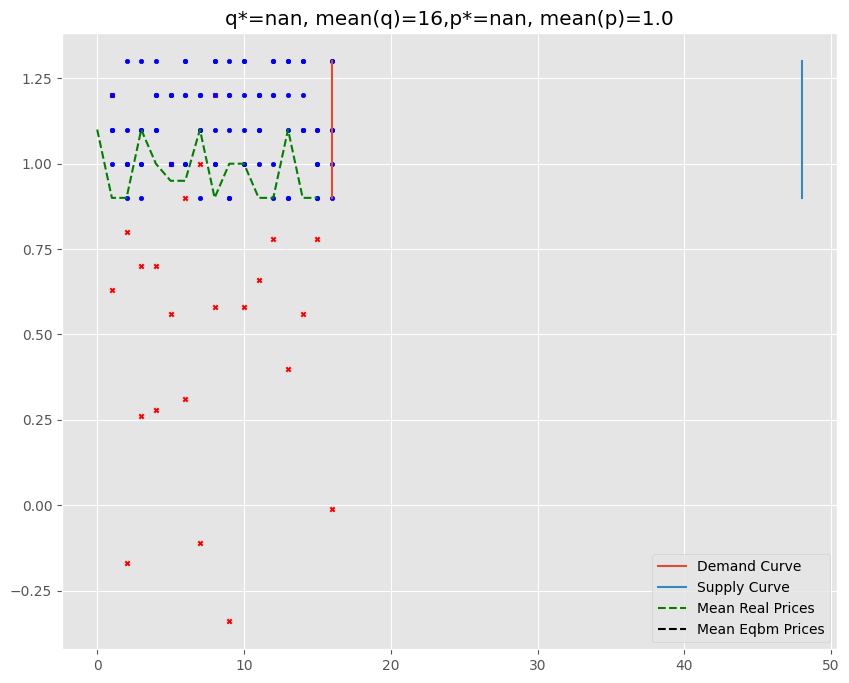

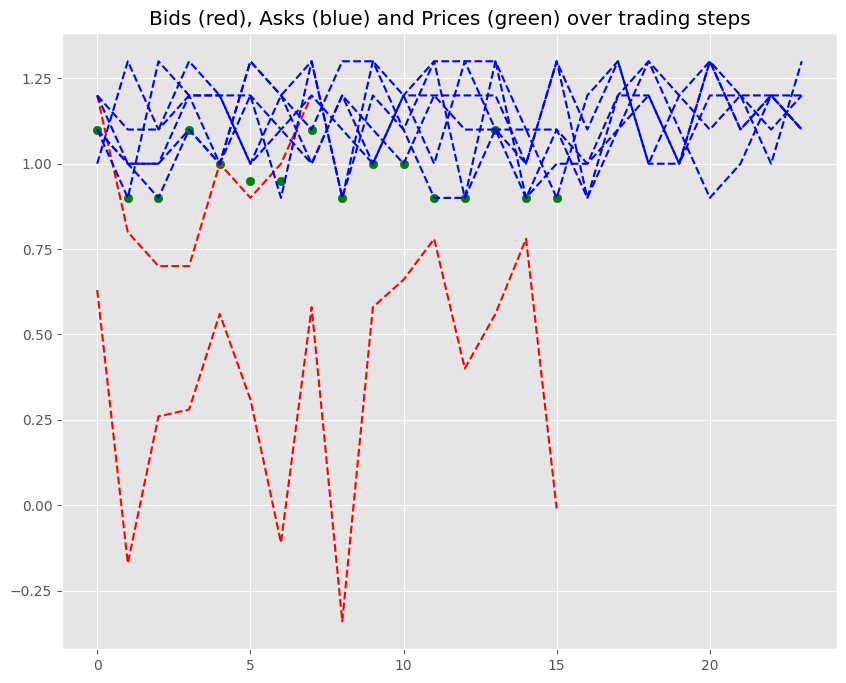

In [552]:
graph_period(env.db, 0, 1000)

### Play Game

In [557]:
# from stable_baselines3 import SAC
from functions import *
loaded_model = SAC.load("trained_sac_model")

# Assuming you have a trained agent loaded as 'loaded_model'
db2 = Database(game_metadata, buyer_strategies, seller_strategies)
db2.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
db2.round_data.token_costs = db.round_data.token_costs 
db2.round_data.redemption_values = db.round_data.redemption_values 
env2 = TradingEnv2(db2, nsteps)

obs, _ = env2.reset()  # Reset the environment to start a new game
done = False
user_id = 1
while not done:
    if (user_id == 0) and (db2.sellers[0].num_tokens_traded <= ntokens):
        db2.sellers[0].next_token()
        print('How the next token would cost if unsold', db2.sellers[0].value)
        print('Current trading step:', env2.timestep)
        user_input = input("Your ask: ")
    elif (user_id == 1) and (db2.buyers[1].num_tokens_traded <= ntokens): 
        db2.buyers[1].next_token()
        print('How the next token value', db2.buyers[1].value)
        print('Current trading step:', env2.timestep)
        user_input = input("Your bid: ")       
        
    user_input = float(user_input)
    action, _ = loaded_model.predict(obs, deterministic=True)  # Get the agent's action
    obs, reward, done, _, _ = env2.step(action, user_input, user_id)  # Take the action and observe the next state

    if (user_id == 0):
        print(db2.step_data.iloc[-1].current_bid, db2.step_data.iloc[-1].current_ask, db2.step_data.iloc[-1].price)
        if db2.step_data.iloc[-1].current_ask_idx == 0 and db2.step_data.iloc[-1].price > 0:
            print('YOUR ASK WON:', db2.sellers[0].step_profit)
        else:
            print('YOUR ASK LOST!')
        print('\n')
    elif (user_id == 1):
        print(db2.step_data.iloc[-1].current_bid, db2.step_data.iloc[-1].current_ask, db2.step_data.iloc[-1].price)
        if db2.step_data.iloc[-1].current_bid_idx == 1 and db2.step_data.iloc[-1].price > 0:
            print('YOUR BID WON:', db2.buyers[1].step_profit)
        else:
            print('YOUR BID LOST!')
        print('\n')
    else:
        pass


How the next token value 1.3
Current trading step: 0


Your bid:  1.2


1.2 1.0 1.1
YOUR BID WON: 0.19999999999999996


How the next token value 1.3
Current trading step: 1


Your bid:  1.2


1.2 0.9 1.05
YOUR BID WON: 0.25


How the next token value 1.3
Current trading step: 2


Your bid:  1.2


1.2 0.9 1.05
YOUR BID WON: 0.25


How the next token value 1.3
Current trading step: 3


Your bid:  1.2


1.2 0.9 1.05
YOUR BID WON: 0.25


How the next token value 1.3
Current trading step: 4


Your bid:  1.2


1.2 0.9 1.05
YOUR BID WON: 0.25


How the next token value 1.3
Current trading step: 5


Your bid:  1.2


1.2 0.9 1.05
YOUR BID WON: 0.25


How the next token value 1.3
Current trading step: 6


Your bid:  1.2


1.2 1.1 1.15
YOUR BID WON: 0.15000000000000013


How the next token value 1.3
Current trading step: 7


Your bid:  1.2


1.2 1.0 1.1
YOUR BID WON: 0.19999999999999996


How the next token value nan
Current trading step: 8


Your bid:  1.2


1.2 1.1 1.2
YOUR BID WON: nan




IndexError: list index out of range

In [172]:
db2.step_data.tail(nsteps)[['current_bid_idx','bprofit','buy']].groupby('current_bid_idx').sum()

,bprofit,buy
current_bid_idx,,
0,13.855,1
1,20.450,3
2,8.400,1


In [174]:
db2.step_data.tail(nsteps)[['current_ask_idx','sprofit','sell']].groupby('current_ask_idx').sum()

,sprofit,sell
current_ask_idx,,
0,24.250,2
1,15.545,2
2,24.600,2


In [168]:
env2.db.step_data

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
0,0,0,0,"[37.84, 46.0, 50.8]","[29.4, 28.8, 29.8]",50.80,2,28.8,1,True,True,39.80,1,11.70,15.30
1,0,0,1,"[39.9, 46.0, 24.3]","[30.9, 38.3, 34.1]",46.00,1,30.9,0,True,True,38.45,1,13.05,13.95
2,0,0,2,"[39.72, 44.0, 41.8]","[39.3, 38.8, 29.7]",44.00,1,29.7,2,True,True,36.85,1,8.15,12.35
3,0,0,3,"[38.36, 35.0, 29.2]","[33.7, 34.3, 48.9]",38.36,0,33.7,0,True,True,36.03,1,15.47,2.93
4,0,0,4,"[34.71, 35.0, 26.6]","[54.1, 42.1, 44.0]",35.00,1,42.1,1,False,True,35.00,1,0.40,1.90
5,0,0,5,"[35.94, 17.0, 44.2]","[51.5, 53.4, 37.1]",44.20,2,37.1,2,True,True,40.65,1,4.35,7.55
6,0,0,6,"[34.45, 17.0, 20.1]","[67.3, 54.1, 52.9]",34.45,0,52.9,2,False,False,NaN,0,0.00,0.00
7,0,0,7,"[9.4, 17.0, 19.0]","[53.7, 64.1, 49.0]",19.00,2,49.0,2,False,False,NaN,0,0.00,0.00
8,0,0,8,"[17.17, 17.0, 18.0]","[67.7, 53.4, 50.4]",18.00,2,50.4,2,False,False,NaN,0,0.00,0.00
9,0,0,9,"[-6.37, 17.0, 29.4]","[60.3, 64.2, 68.3]",29.40,2,60.3,0,False,False,NaN,0,0.00,0.00


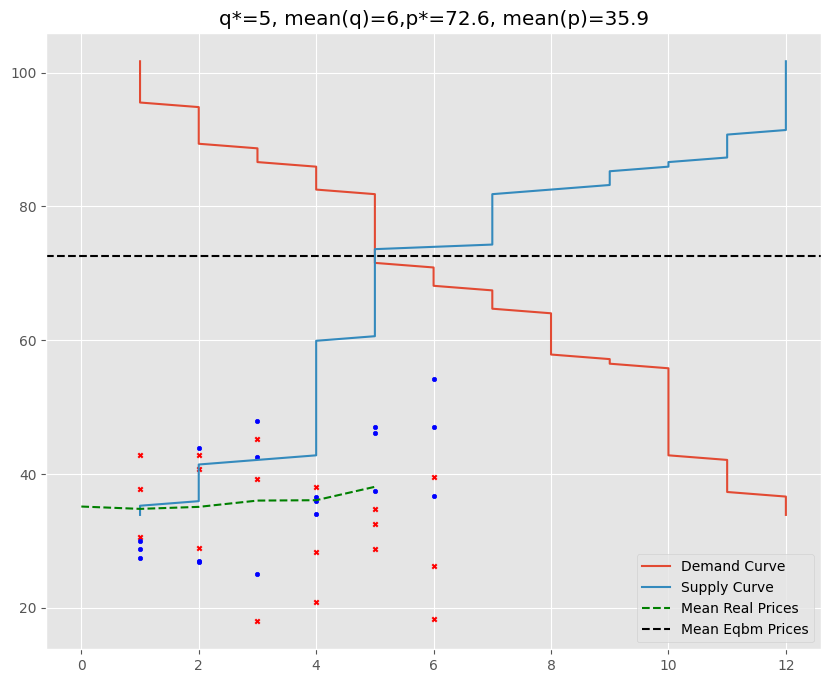

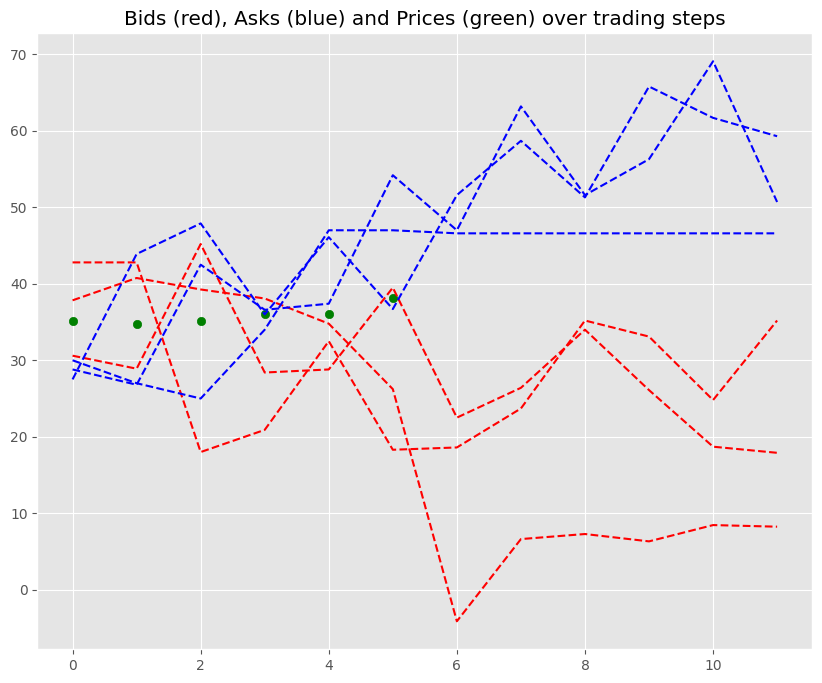

In [159]:
graph_period(env2.db, 0, 0)

In [23]:
env2.db.step_data

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit


In [555]:
class TradingEnv2(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.rnd = 0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = spaces.Box(0,1,(1,),dtype=np.float32)
        self.observation_space = spaces.Box(-1,200,(13,),dtype=np.float32)

    def reset(self,seed=None):
        #self.db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
        self.db.reset_period(self.rnd)
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        self.timestep = 0
        self.period += 1
        self.db.buyers[0].next_token()
        agent = self.db.buyers[0]
        observation = np.array([0,-1,-1,-1,-1,-1,-1,-1,agent.value,-1,-1,-1,agent.num_tokens_traded], dtype = np.float32)
        return observation, {}

    def step(self, action, user_action, user_id, seed=None, options=None):
        [buyer.next_token() for buyer in self.db.buyers if buyer.num_tokens_traded <= ntokens]
        [seller.next_token() for seller in self.db.sellers if seller.num_tokens_traded <= ntokens]
        bid_frac = action.item()
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]

        if user_id == 0:
            asks[0] = user_action
        elif user_id == 1:
            bids[1] = user_action
        else:
            pass
            
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask, current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # compute reward, new state
        reward = 0.0
        if sale == 1 and current_bid_idx == 0:
            reward = bprofit
            
        agent = self.db.buyers[0]
        observation = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded],dtype = np.float32)
        idx = np.isnan(observation)
        observation[idx] = -1.0
        # check termination
        self.timestep += 1
        if self.timestep == nsteps:
            terminated = True
            self.timestep = 0
        else:
            terminated = False
        infos = {"TimeLimit.truncated":True}
        truncated = False
        return observation, reward, terminated, truncated, infos